# Use optimizer to find n,k for known thickness and to find thickness for known n,k.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.TimeDomain_extractor import TimeDomainExtractorNK, TimeDomainExtractorD

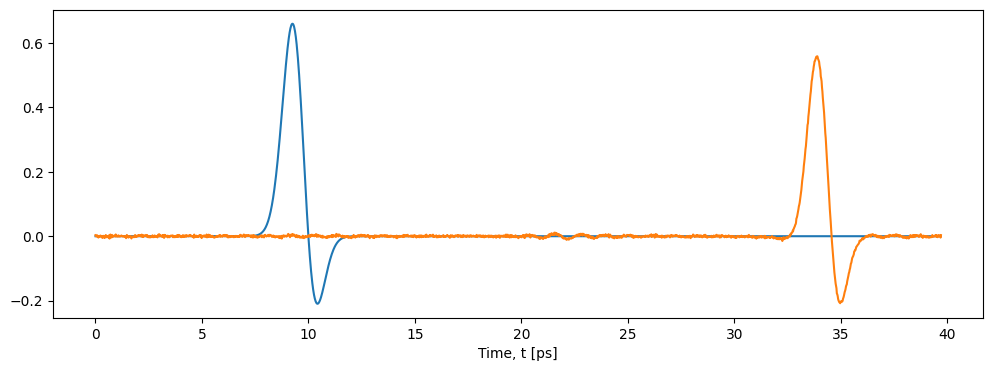

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**11  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n = 3.46
k = 0.01

# Experimental material parameters (ground truth)
material_params_exp = [(n+1j*k, 3 * 1e-3)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0.002)
experimental_pulse = experimental_pulse[:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

## Extract n & k for known D (thickness)

In [3]:
n_init, k_init, D = 3.40, 0.015, 3e-3
TDE = TimeDomainExtractorNK(reference_pulse, experimental_pulse, deltat, n_init, k_init, D, lr=0.001)
optimized_n, optimized_k = TDE.optimize(num_iterations=150, updates=10)

initial_params = [(n_init + 1j*k_init, D)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Iteration 0, Loss: 0.007956989109516144, n: 3.4010000228881836, k: 0.01400000136345625
Iteration 10, Loss: 0.006171123590320349, n: 3.4035141468048096, k: 0.004969202447682619
Iteration 20, Loss: 0.004391108639538288, n: 3.4100937843322754, k: -0.0032864869572222233
Iteration 30, Loss: 0.003207119181752205, n: 3.4177846908569336, k: -0.00911042932420969
Iteration 40, Loss: 0.0024464374873787165, n: 3.425194025039673, k: -0.012157636694610119
Iteration 50, Loss: 0.0018969961674883962, n: 3.4319801330566406, k: -0.012714359909296036
Iteration 60, Loss: 0.00143432745244354, n: 3.4380998611450195, k: -0.011272797361016273
Iteration 70, Loss: 0.0010241168783977628, n: 3.443577527999878, k: -0.008330466225743294
Iteration 80, Loss: 0.0006489228690043092, n: 3.4484047889709473, k: -0.004368159919977188
Iteration 90, Loss: 0.00034363759914413095, n: 3.4525160789489746, k: 9.286825661547482e-05
Iteration 100, Loss: 0.00013377724098972976, n: 3.455803155899048, k: 0.004425465129315853
Iteration 

[((3.4600589275360107+0.010080309584736824j), 0.003)]


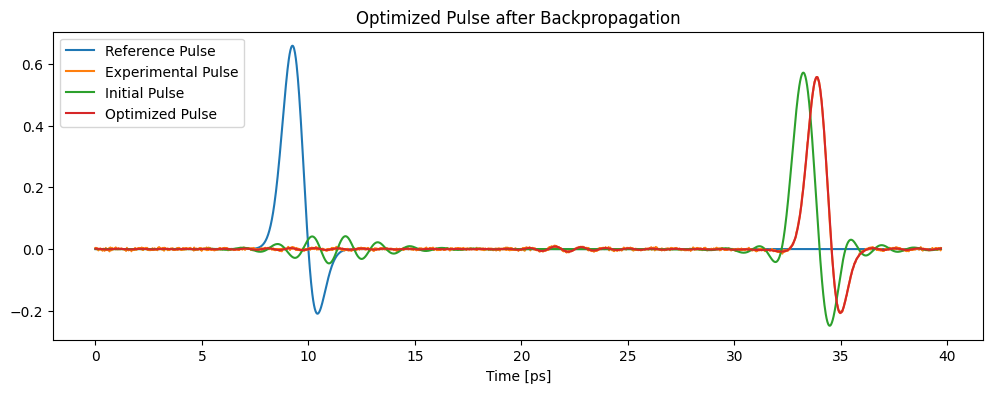

In [4]:
best_params = [(optimized_n + 1j*optimized_k, D)]
# TODO: find 
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()

## Finding D for known n & k

In [5]:
D_init = 3.3 * 1e-3
TDE_D = TimeDomainExtractorD(reference_pulse, experimental_pulse, deltat, n, k, D_init, lr=0.01)
optimized_D = TDE_D.optimize(num_iterations=150, updates=10, alpha=1)

initial_params = [(n + 1j*k, D_init)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Iteration 0, Loss: 0.01305082906037569, D: 0.003333166241645813
Iteration 10, Loss: 0.013248207047581673, D: 0.003441843204200268
Iteration 20, Loss: 0.012824754230678082, D: 0.003456620965152979
Iteration 30, Loss: 0.012421250343322754, D: 0.0034543387591838837
Iteration 40, Loss: 0.01285418588668108, D: 0.0034635968040674925
Iteration 50, Loss: 0.01281826663762331, D: 0.003467582631856203
Iteration 60, Loss: 0.012835699133574963, D: 0.003466517897322774
Iteration 70, Loss: 0.012836147099733353, D: 0.003466603811830282
Iteration 80, Loss: 0.01282423548400402, D: 0.0034667279105633497
Iteration 90, Loss: 0.012817217968404293, D: 0.00346684199757874
Iteration 100, Loss: 0.012835986912250519, D: 0.0034669162705540657
Iteration 110, Loss: 0.012810087762773037, D: 0.003466954454779625
Iteration 120, Loss: 0.012826690450310707, D: 0.003466990776360035
Iteration 130, Loss: 0.012806275859475136, D: 0.0034669856540858746
Iteration 140, Loss: 0.012827330268919468, D: 0.00346695096231997


[((3.46+0.01j), 0.003456678707152605)]


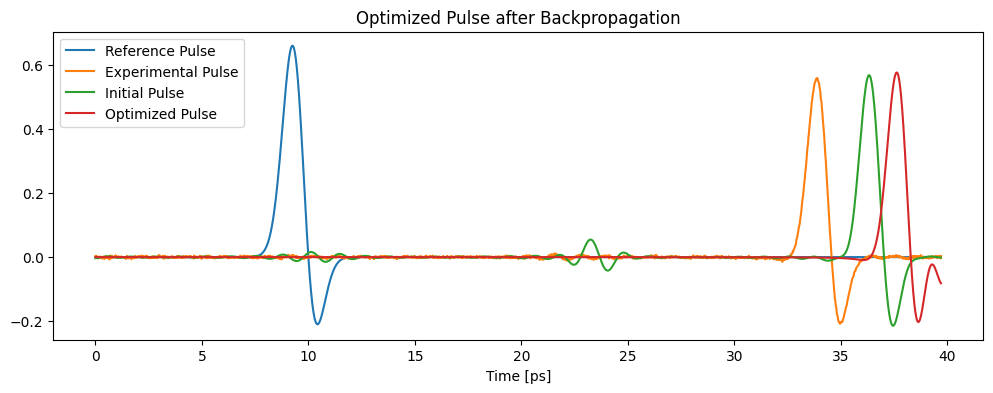

In [6]:
best_params = [(n + 1j*k, optimized_D)]
# TODO: find 
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()